In [4]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pickle
import time
import matplotlib.pyplot as plt
import collections

# 1. Data

In order to create our graph, we first performed some preprocessing on the three dataframes we downloaded.
Specifically, the function load_dfs, checks if the processed dataframes already exist: if they do, it simply loads them, otherwise it performs the following steps on the raw txt files:

1. Converts the time from the UNIX format to datetime.<br><br>

2. Filters the dataframe in order to take only the entries more recent than the given threshold date.<br><br>

3. Performs min-max scaling on the unix time, and put the scaled values in a column called weights. It's important    to specify that what we actually implemented is the opposite of the traditional min-max scaling: rather than           measuring the distance from the minimum and dividing it by the interval between minimum and maximum, we're             taking the distance from the maximum in the numerator. This allows us to have higher weights (i.e. higher             distances) for less recent interactions and smaller weights for the more recent ones. The idea is to penalize         less recent entries.<br><br>

4. Save the files as binary pickle files.<br><br>

In [5]:
def load_dfs(threshold):
    
    if "df_a2q" not in os.listdir("files") \
    or "df_c2q" not in os.listdir("files") \
    or "df_c2a" not in os.listdir("files"):
    
        file_names = ["files/sx-stackoverflow-a2q.txt",
                      "files/sx-stackoverflow-c2q.txt",
                      "files/sx-stackoverflow-c2a.txt"]

        columns = [["user_answering", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_answering", 
                    "time_u"]]

        df_a2q_raw = pd.read_csv(file_names[0],
                                 delim_whitespace=True,
                                 names=columns[0])

        df_c2q_raw = pd.read_csv(file_names[1],
                                 delim_whitespace=True,
                                 names=columns[1])

        df_c2a_raw = pd.read_csv(file_names[2],
                                 delim_whitespace=True,
                                 names=columns[2])
        
        
        dfs_raw = [df_a2q_raw, df_c2q_raw, df_c2a_raw]

        print(df_a2q_raw.shape)

        # add a column for a standard visualization of dates
        for df in dfs_raw:
            df["time_h"] = pd.to_datetime(df["time_u"], unit="s")

        names = ["a2q", "c2q", "c2a"]
        for i, df in enumerate(dfs_raw):
            most_recent = df["time_h"].max()
            name = names[i]
            print(f"Most recent date for dataset {name}: {most_recent}")

        print(f"Date threshold selected: {threshold}")

        df_a2q = df_a2q_raw[df_a2q_raw["time_h"] > threshold].copy()
        df_c2q = df_c2q_raw[df_c2q_raw["time_h"] > threshold].copy()
        df_c2a = df_c2a_raw[df_c2a_raw["time_h"] > threshold].copy()

        dfs = [df_a2q, df_c2q, df_c2a]
        for df in dfs:
            min_el = df["time_u"].min()
            max_el = df["time_u"].max()
            
            # variation on min max scaler so to have values closer to the max -> to 0 and values
            # closer to the min -> to 1.
            df["weight"] = (max_el - df["time_u"]) / (max_el - min_el)
            
            df.drop("time_u", inplace=True, axis=1)

        with open("files/df_a2q", "wb") as file:
            pickle.dump(df_a2q, file)

        with open("files/df_c2q", "wb") as file:
            pickle.dump(df_c2q, file)

        with open("files/df_c2a", "wb") as file:
            pickle.dump(df_c2a, file)
    
    else:
        
        with open("files/df_a2q", "rb") as file:
            df_a2q = pickle.load(file)
        
        with open("files/df_c2q", "rb") as file:
            df_c2q = pickle.load(file)
            
        with open("files/df_c2a", "rb") as file:
            df_c2a = pickle.load(file)
    
    return df_a2q, df_c2q, df_c2a

In [6]:
names = ["a2q", "c2q", "c2a"]

In [7]:
threshold = datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0)
df_a2q, df_c2q, df_c2a = load_dfs(threshold=threshold)

Once we're finished, we obtain the following general structure for each dataframe:

In [8]:
df_a2q.head()

,user_answering,user_questioning,time_h,weight
10861428,95190,960750,2014-01-01 00:00:05,1.0
10861429,607314,2635650,2014-01-01 00:00:12,1.0
10861430,301857,1549201,2014-01-01 00:00:16,1.0
10861431,1419954,1897577,2014-01-01 00:00:21,1.0
10861432,254252,3065375,2014-01-01 00:00:23,1.0


In [9]:
df_c2q.head()

,user_commenting,user_questioning,time_h,weight
9576868,976391,3061211,2014-01-01 00:00:08,1.0
9576869,445131,2489834,2014-01-01 00:00:24,1.0
9576870,1832636,2721870,2014-01-01 00:00:27,1.0
9576871,822711,3136232,2014-01-01 00:00:28,1.0
9576872,22656,1693074,2014-01-01 00:00:34,1.0


In [10]:
df_c2a.head()

,user_commenting,user_answering,time_h,weight
14958295,22656,22656,2014-01-01 00:00:08,1.0
14958296,2224701,23385,2014-01-01 00:00:14,1.0
14958297,2732801,2732801,2014-01-01 00:00:21,1.0
14958298,1965449,2325987,2014-01-01 00:00:22,1.0
14958299,26742,26742,2014-01-01 00:00:23,1.0


We create a list containing the three dataframes since it will make it easier to process the data within.

In [11]:
dfs = [df_a2q,
       df_c2q,
       df_c2a]

Next, we created our Graph class. For what concerns the underlying data structure, we decided to implement a dictionary of dictionaries (of dictionaries of dictionaries). <br>There are mainly two reason for this choice:<br><br>
1. First, with dictionaries accessing the details for each edge is extremely fast and convenient, while with other data structure we would have probably needed several loops for many operations.<br><br>
2. this implementation is similar to the one used by networkX and this has allowed us to use seamlessly the visualization functions contained in that library.<br><br>

For what concerns the class function itself, we implemented a ***create_graph*** method that builds the graph according to the following structure:

**self.graph** -> Our entire graph, indexed by node.<br><br>
**self.graph[node "A"]** -> dictionary indexed by the neighbors of "A".<br><br>
**self.graph[node "A"][node "B"]** -> dictionary indexed by the time the interation took place.<br><br>
**self.graph[node "A"][node "B"][time "x"]** -> final dictionary with details (specifically type of interaction and edge weight) of the interaction between user A and B that took place at time x.<br><br>

Since this process takes about 90 minutes to complete, we created a ***save_graph*** function and a ***load_graph*** function to avoid having to recreate the graph each time.

We also created a ***get_random_subgraph*** method that, starting from a random node, walks the graph and returns us a subgraph. This was mainly done to test our functionalities on a lighter, less cumbersome graph.

In [32]:
class Graph:
    
    def __init__(self):
        self.graph = {}
                
    
    @time_wrapper
    def create_graph(self, sources, names):
        """
        Args:
            sources: dataframes from which to create the graph
            names: a list of string containing the names of the graph used in order to label the edges accordingly
        
        Summary:
            Creates a graph with the following structure:
            
            self.graph -> Our entire graph, indexed by node
            self.graph[node "A"] -> dictionary indexed by the neighbors of "A"
            self.graph[node "A"][node "B"] -> dictionary indexed by the time the interation took place
            self.graph[node "A"][node "B"][time "x"] -> details (specifically, type of interaction and edge weight) of the
                                                        of the interaction between user A and B that took place at time x            
        """
        
        self.graph = {}
    
        for i_source, source in enumerate(sources):
            nodes_column = source.iloc[:, 0]
            nodes = nodes_column.unique()
            type_of_interaction = names[i_source]
            
            for node in tqdm(nodes):
                if node not in self.graph.keys():
                    self.graph[node] = {}
                # take the subset of the dataframe of the entries for "node"
                node_subdf = source[nodes_column == node]
                neighbors = node_subdf.iloc[:, 1].values
                times_h = node_subdf.iloc[:, 2].values
                weights = node_subdf.iloc[:, 3].values
                for i, neighbor in enumerate(neighbors):
                    # Here we want to make sure that even if a node figures only as a neighbor, it still exists as 
                    # a node in our graph.
                    if neighbor not in self.graph.keys(): 
                        self.graph[neighbor] = {}
                    if neighbor not in self.graph[node].keys():
                        self.graph[node][neighbor] = {}
                        
                    self.graph[node][neighbor][times_h[i]] = {"weight": weights[i], 
                                                              "type_of_interaction": type_of_interaction}
        
    
    @time_wrapper
    def save_graph(self, path):
        """
        Args:
            path: name of file where we want the file stored
        Summary:
            Saves graph as a binary file.
        """
        
        with open(path, "wb") as file:
            pickle.dump(self.graph, file)

    
    @time_wrapper
    def load_graph(self, path):
        """
        Args:
            path: name of file to load the graph from.
        Summary:
            Load graph from binary file.
        """
        
        with open(path, "rb") as file:
            self.graph = pickle.load(file)
    
    
    def get_random_subgraph(self, n_nodes=100000):
        np.random.seed(42)
        bad_starting_node = True
        while bad_starting_node:
            random_node = np.random.choice(list(self.graph.keys()))
            if len(self.graph[random_node].keys()) > 10:
                bad_starting_node = False
        print(f"Starting node: {random_node}")
        print(f"Degree of starting node: {len(self.graph[random_node].keys())}")
        subgraph = {random_node: {}}
        to_check = [random_node]
        i = 0
        
        while len(subgraph.keys()) < n_nodes:
            node = to_check[i]
            if node not in subgraph.keys() or len(subgraph[node].keys()) < 1:
                for neighbor in self.graph[node].keys():
                    if neighbor not in to_check:
                        to_check.append(neighbor)
                    if neighbor not in subgraph.keys():
                        subgraph[neighbor] = {}
                    subgraph[node][neighbor] = self.graph[node][neighbor]
                    if len(subgraph.keys()) >= n_nodes:
                        break
            i += 1
        
        return subgraph
    
    
    def dijkstra(self, start_node, end_node, gr, visualization=True):
        unvisited = []
        for key in gr.keys():
            if key not in unvisited:
                unvisited.append(key)
        visited = []
        
        min_distances = {key: (np.inf, None) for key in gr.keys()}
        min_distances[start_node] = (0, None)
        
        current_node = start_node
        
        while current_node != end_node:
            visited.append(current_node)
            unvisited.remove(current_node)
            for neighbor in gr[current_node].keys():
                weights = [gr[current_node][neighbor][time_key]["weight"] for time_key in gr[current_node][neighbor].keys()]
                weight = np.min(weights)
                tot = min_distances[current_node][0] + weight
                if tot < min_distances[neighbor][0]:
                    min_distances[neighbor] = (tot, current_node)
            
            min_unvisited = np.inf
            found_something = False
            for candidate in unvisited:
                if min_distances[candidate][0] < min_unvisited:
                    min_unvisited = min_distances[candidate][0]
                    current_node = candidate
                    found_something = True
            
            if not found_something:
                break
        
        node_a = None
        node_b = end_node
        
        path = []
        while node_a != start_node:
            node_a = min_distances[node_b][1]
            if node_a == None:
                break
            path.append((node_a, node_b))
            node_b = node_a
        
        if len(path) <= 0:
            print("No path found.")
        
        else:
            path = path[::-1]
            if visualization:
                visualize_network(gr, path, alpha=0.1, labelled=[start_node, end_node])
        
        return path, min_distances
    
    
    def get_neighbors(self, node, interaction="all"):
        """
        Args:
            node: the node we want the neighbors of.
            interaction: the label of the edges we're interested in, default=all, meaning we will obtain all
                         neighbors of that node, regardless of the type of interactions.
        Summary:
            Obtains all the neighbors of a specific node.
        """
        
        if interaction == "all":
            neighbors = list(self.graph[node].keys())
        else:
            neighbors = []
            for neighbor in self.graph[node].keys():
                if self.graph[node][neighbor][0] == interaction:
                    neighbors.append(neighbor)
        
        return neighbors
        

Finally, we also implemented two utility functions:

1. ***time_wrapper*** is a very simple decorator that was useful to time our implementations.<br><br>

2. ***visualize network*** uses the functionalities contained in the library networkX to visualize specific subgraphs. It takes as argument the graph to plot and a list containing the edges we want to highlight. If this last parameter is not provided, all the edges will be black. 

In [47]:
def time_wrapper(func):
    """
    Summary:
        Decorator to time functions. A print statement containing the running time of the function will be printed.
    
    Args:
        the function that has to be decorated.
    """
    def wrapped(*args, **kwargs):
        start = time.time()
        r = func(*args, **kwargs)
        print(f"Time elapsed: {time.time()-start}")
        return r
    return wrapped


def visualize_network(graph, edges_to_highlight=[], alpha=0.2, highlight_nodes=True, labelled=[]):
    
    """
    Summary:
        Visualizes a graph using the networkX module. If edges_to_highlight is provided, it highlights in red
        the desired edges.
    
    Args:
        graph(dict): a dictionary representing the graph to be plotted.
        edges_to_highlight: the edges that have to be highlighted.
        alpha: the transparency value for the edges that are not to be highlighted.
        highlight_nodes: a boolean signaling whether we also want the nodes corresponding to the highlighted edges
                         to be highlighted.
    
    """
    
    nx_g = nx.MultiGraph(graph)
    black_edges = [edge for edge in nx_g.edges() if edge not in edges_to_highlight]
    nodes_to_highlight=[]
    if highlight_nodes:
        for edge in edges_to_highlight:
            for node in edge:
                if node not in nodes_to_highlight:
                    nodes_to_highlight.append(node)
        blank_nodes = [node for node in nx_g.nodes() if node not in nodes_to_highlight]
    
    plt.figure(figsize=(30, 20))
    pos = nx.spring_layout(nx_g)
    
    if len(labelled) > 0:
        labels_d = {node: "" for node in nx_g.nodes}
        for label in labelled:
            labels_d[label] = str(label)
        
    
    nx.draw_networkx_nodes(nx_g, 
                           pos, 
                           cmap=plt.get_cmap('jet'), 
                           node_size = 200, 
                           nodelist=nodes_to_highlight, 
                           node_color="r")
    
    nx.draw_networkx_nodes(nx_g, 
                           pos, 
                           cmap=plt.get_cmap('jet'), 
                           node_size = 200, 
                           nodelist=blank_nodes, 
                           alpha=alpha)
    
    nx.draw_networkx_edges(nx_g, 
                           pos, 
                           edgelist=edges_to_highlight, 
                           edge_color='r',
                           width=5.0,
                           arrows=True)
    
    nx.draw_networkx_edges(nx_g, 
                           pos, 
                           edgelist=black_edges, 
                           alpha=alpha, 
                           arrows=True)
    
    nx.draw_networkx_labels(nx_g,
                            pos,
                            labels_d,
                            font_size=16,
                            font_weight="bold",
                            font_color="yellow")
    
    plt.show()

Finally, we build our graph. (or load it if we have already built it).

In [ ]:
g = Graph()

if "merged_graph.p" in os.listdir("files"):
    g.load_graph("files/merged_graph.p")
else:
    g.create_graph(dfs, names=names)
    g.save_graph("files/merged_graph.p")

If we need a smaller subgraph, we can also load a lighter version made of just 100000 nodes, created with the get_random_subgraph method.

In [37]:
# This for lightweight graph

g = Graph()
g.load_graph("files/merged_graph_lw_2.p")

Time elapsed: 1.8439459800720215


# 2. Implementation of the backend

In [72]:
def user_interface():
    
    selection = 0
    print("Here's a list of the available functions:\n\n"
          "Function 1: Overall features of graph\n"
          "Function 2: Best user\n"
          "Function 3: Shortest ordered route\n"
          "Function 4: Disconnect nodes")
    print("*"*40)
    
    while selection != "q":
        selection = input("Select the number of the function (q to exit): ")
        print()
        if selection == "1":
            print("You want to retrieve the overall features of the graph.\n")
            pass
        elif selection == "2":
            print("You want to find the best user.\n")
            pass
        elif selection == "3":
            print("You want to find the shortest ordered route.\n")
            pass
        elif selection == "4":
            print("You want to disconnect two nodes\n")
            pass
        elif selection != "q":
            print("Selection not valid.")
    

In [73]:
user_interface()

Here's a list of the available functions:

Function 1: Overall features of graph
Function 2: Best user
Function 3: Shortest ordered route
Function 4: Disconnect nodes
****************************************
Select the number of the function (q to exit): q



## Functionality 1

In [ ]:
def overallFeatures(g : Graph):
    directed = False
    nodes = g.graph
    ncoment = 0
    for node in nodes:
        nes = g.get_neighbors(node)
        ncoment += len(nes)
        for ne in nes:
            if not node in g.get_neighbors(ne):
                directed = True
    if not directed:
        print('This graph is not directed')
        print('This graph as', len(nodes),'users')
        print('This graph as',ncoment/2,'answers/comments')
        print('This graph as on average', len(nodes)/(ncoment/2), 'link per user')
    else:
        print('This graph is directed')
        print('This graph as', len(nodes),'users')
        print('This graph as',ncoment,'answers/comments')
        print('This graph as on average', len(nodes)/ncoment, 'link per user')
    d = ncoment/(len(nodes)*(len(nodes) -1))
    print('The graph density is', d)
    if d < .5:
        print('The graph is Sparse ')
    else:
        print('The graph is dense')

In [ ]:
overallFeatures(g)

## Functionality 2

In [ ]:
def selecttime(gr, time: tuple):
    """
    Selects a subgraph that whose entries are within the time interval
    :param gr:       initial graph
    :param time:     tuple (start time, end time) in yyyy-mm-dd format
    :returns:        subgraph whose edges are in the time interval
    """
    for key in list(gr.graph.keys()):
        for stuff in list(gr.graph[key].keys()): ## gr.get_neighbors(key)
            for tup in gr.graph[key][stuff]:
                timegraph = str(tup[2])
                truetime = datetime.strptime(timegraph[:10], "%Y-%m-%d")
                start = datetime.strptime(time[0], "%Y-%m-%d")
                end = datetime.strptime(time[1], "%Y-%m-%d")
                if not (truetime > start and truetime < end):
                    gr.graph[key][stuff].remove(tup)
            if gr.graph[key][stuff] == []:
                gr.graph[key].pop(stuff)
        if gr.graph[key] == []:
            gr.graph.pop(key)
    return gr

def matrixfromgraph(gr):
    """
    Creates adjacency matrix normalized over rows
    :param:       graph
    :returns:     adjacency matrix normalized over rows
    """
    keys = list(gr.graph.keys())
    ris = np.zeros((len(keys), len(keys)))
    for i in range(len(keys)):
        for j in range(len(keys)):
            if keys[j] in gr.graph[keys[i]]:
                for tup in gr.graph[keys[i]][keys[j]]:
                    ris[i][j] += tup[1]
        if np.sum(ris[i]):
            ris[i] /= np.sum(ris[i])
    return ris

def shortlength(gr, start, end):
    """
    finds the shortest path from one node to another using a mechanism similar to dijsktra's algorithm 
    keeping info on the nodes that lead to the path
    :param gr:      graph
    :param start:   starting node
    :param end:     end node
    :returns:       list of ordered nodes in the shortest path
    
    """
    dic = distances(gr, start)
    path = []
    current = end
    while current is not None:
        path.append(current)
        if current in dic.keys():
            app = dic[current][0]
            current = app
        else:   
            # returns empty list if path does not exist
            # (it should, since we are considering cc of the graph)
            print('Attention')
            return [] 
    path = path[::-1]
    return path

def component(gr, node):
    """ 
    Returns the connected component of the graph gr that contains the node 
    (if edges spawn from it)
    :param gr: the graph
    :param node: the node that we are interested in
    :returns 
    """
    ris = Graph()
    vis = set()
    current = node
    to_do = {i for i in gr.get_neighbors(node)}
    while len(to_do):
        vis.add(current)
        if current in gr.graph.keys():
            ris.graph[current] = {}
            for edge in gr.graph[current].keys():
                ris.graph[current][edge] = gr.graph[current][edge]
                if edge not in vis:
                    to_do.add(edge)
        current = to_do.pop()
    return ris
  
def distances(gr, start):
    """
    Returns a dictionary whose values indicate the total distance from the starting
    node and the node that precedes them in the shortest path
    :param gr:     the graph that is being considered
    :param start:  the starting node
    :returns:      dictionary in the form dic[key] = (preceding_node, start-key distance)
    """
    dic = {start: (None, 0)} #in this dictionary the node is the key and the value is a tuple
    # made of the node that leads to this node and the total distance from the stating point
    current = start
    vis = set()
    i = 0
    while True:
        # print(i)
        i += 1
        vis.add(current)
        if current in gr.graph.keys():
            neighbors = gr.get_neighbors(current)
            len_so_far = dic[current][1]
            for node in neighbors:
                newweight = min([tup[1] for tup in gr.graph[current][node]])
                weight = newweight + len_so_far
                if node not in dic:
                    dic[node] = (current, weight)
                else:
                    current_shortest_weight = dic[node][1]
                    if current_shortest_weight > weight:
                        dic[node] = (current, weight)      
            new = {node: dic[node] for node in dic if node not in vis}
        else:
            new.pop(current)
        if not new:
                return dic
        current = min(new, key=lambda k: new[k][1])

In [ ]:
def functionality_2(user: int, time: tuple, metric: str):
    gtime = component(g, user)
    gtime = selecttime(gtime, time)
    gtime = component(gtime, user)
    keylist = list(gtime.graph.keys())
    lenlist = len(keylist)
    if metric == 'Betweenness':
        ris = -1
        dicuser = distances(gtime, user)
        for i in tqdm(selecttime(g, time).graph.keys()):
            diclen = distances(component(selecttime(g, time), i), i)
            if user in diclen.keys():
                for j in set(diclen.keys() and dicuser.keys()):
                    if diclen[j][1] == diclen[user][1] + dicuser[j][1]:
                        ris += 1
        lenlist = len(selecttime(g, time).graph.keys())
        tot = (lenlist ** 2 - lenlist)
        if tot == 0:
            return 'There is a problem'
        return ris/tot
    if metric == 'PageRank':
        M = matrixfromgraph(gtime)
        vec = np.ones((M.shape[1], 1))/M.shape[1]
        vec = vec
        M2 = .85 * M + .15 / M.shape[1]
        for _ in range(50):
            vec = M2 @ vec
        return vec
    if metric == 'ClosenessCentrality':
        ris = distances(gtime, user)
        dist = np.sum([ris[j][1] for j in ris.keys()])
        if dist == 0:
            return 'There is a problem'
        return (lenlist - 1)/dist
    if metric == 'DegreeCentrality':
        ris = 0
        for i in gtime.graph[user].keys():
            for t in gtime.graph[user][i]:
                ris += 1
        return ris

## Functionality 3 <br>(Temporarily: Alessandro's. Not complete yet)

In [16]:
subg = g.get_random_subgraph(n_nodes=1000)

Starting node: 1750757
Degree of starting node: 385


In [ ]:
def find_good_nodes(gr, starting_node=None):
    
    if not starting_node:
        for key_1 in gr.keys():
            if len(gr[key_1].keys()) > 3:
                for key_2 in gr[key_1].keys():
                    if len(gr[key_2].keys()) > 2:
                        print(key_1, key_2)
                        return
    else:
        for key in subg[starting_node].keys():
            if len(list(subg[key].keys())) > 3:
                print(starting_node, key)

In [ ]:
find_good_nodes(subg, 1750757)

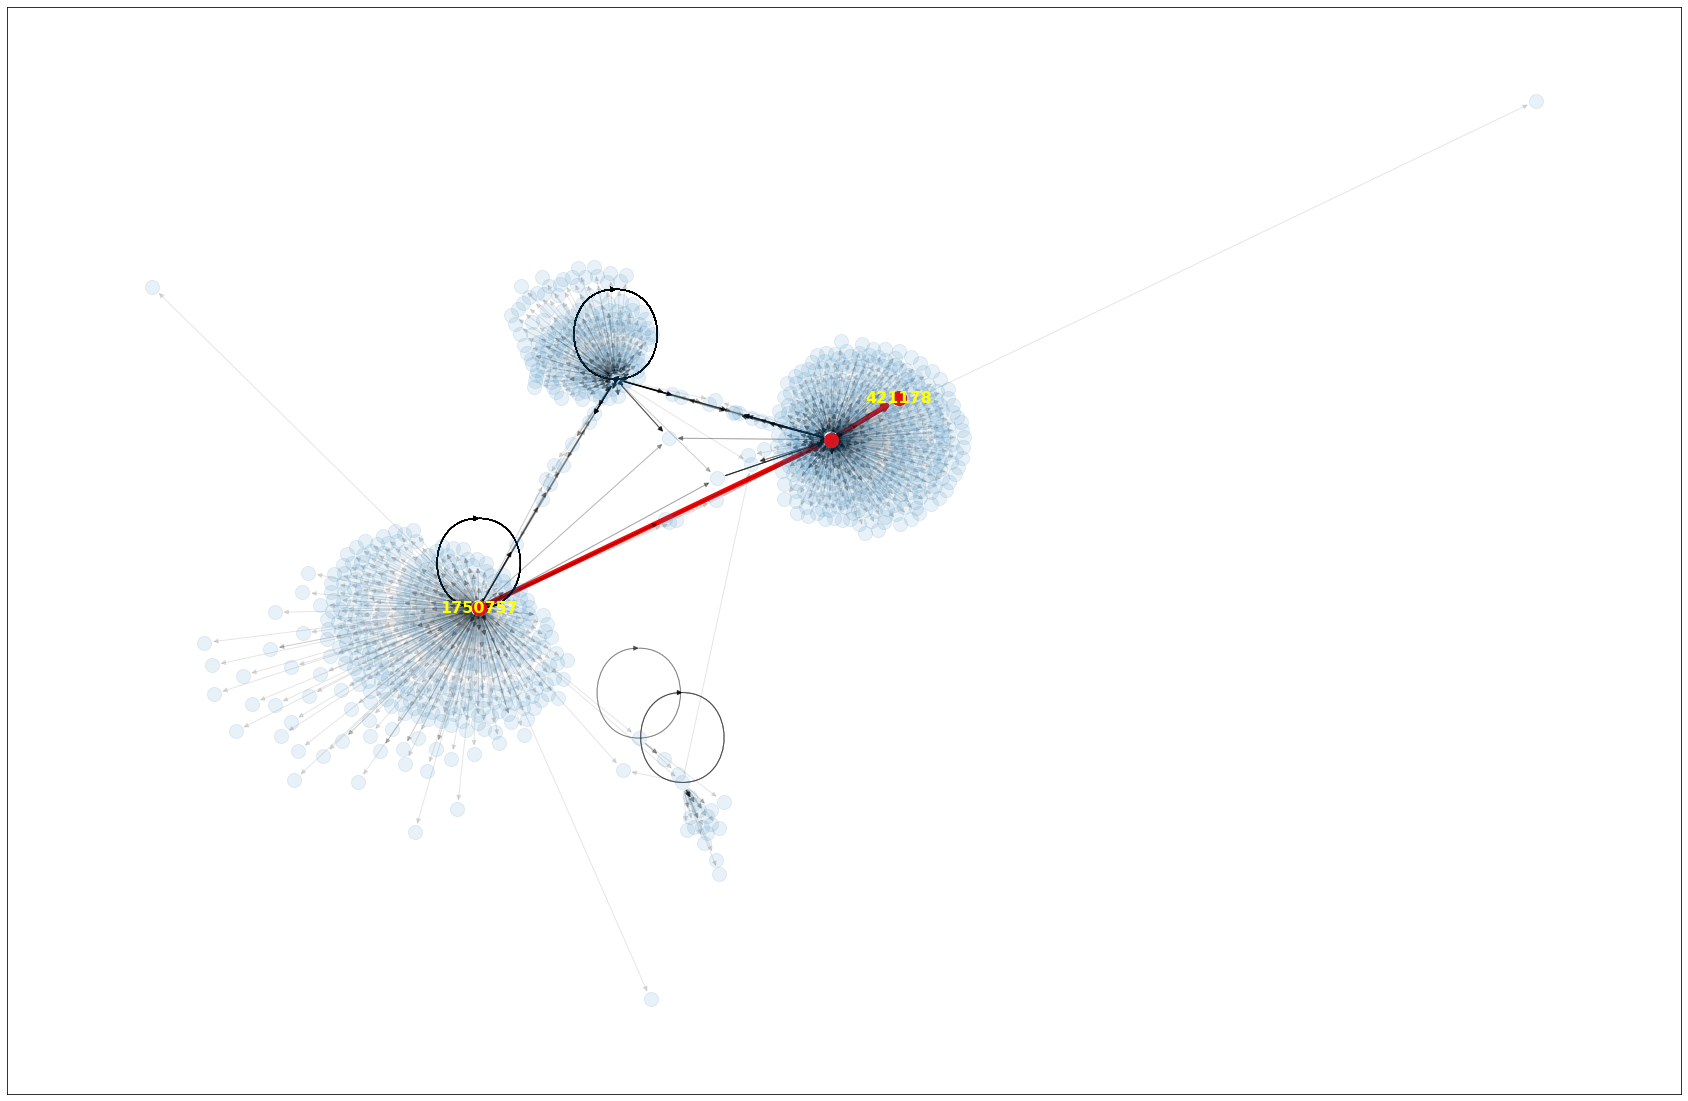

In [48]:
path, min_distances = g.dijkstra(start_node=1750757,
                                 end_node=421178,
                                 gr=subg)

## Functionality 4 (Work in progress)

First, we created a get_df_for_time_interval function that allows for quick retrieval of the edges for a specific time interval. It takes as input the dataframes containing the information for each stackoverflow interaction and filters them according to the given start and end date.

In [69]:
def get_df_for_time_interval(start, end, dfs, names):
    
    """
    Summary:
        returns a subset of the dataframes given in input containing all the interactions 
        relevant for a given time frame.
    
    Args:
        start: datetime from which we want to filter entries.
        end: datetime up to which we want to filter entries.
        dfs: dataframes to use to collect the data.
        names: names of the dataframes.
    """
    
    start = datetime.strptime(start, "%d %B %Y %H:%M:%S")
    end = datetime.strptime(end, "%d %B %Y %H:%M:%S")
    print(f"start: {start}")
    print(f"end: {end}")
    
    subdfs = []
    
    for i, df in enumerate(dfs):
        sub_df = df[df["time_h"] >= start]
        sub_df = sub_df[sub_df["time_h"] < end]
        sub_df.columns = ["user_a", "user_b", "time_h", "weight"]
        sub_df["type"] = names[i]
        subdfs.append(sub_df)
    
    return pd.concat(subdfs, axis=0)

In [70]:
start_1 = "10 June 2015 15:00:00"
end_1 = "10 June 2015 19:00:00"

df_g1 = get_df_for_time_interval(start_1, end_1, dfs, names)

start: 2015-06-10 15:00:00
end: 2015-06-10 19:00:00


In [71]:
def get_subgraph_from_df(df):
    subg = {}
    nodes = np.unique(df["user_a"].values)
    for node in nodes:
        
        if node not in subg.keys():
            subg[node] = {}
        
        subdf = df[df["user_a"]==node]
        neighs = subdf["user_b"].values
        times = subdf["time_h"].values
        weights = subdf["weight"].values
        type_of_interaction = subdf["type"].values
        
        for i, neigh in enumerate(neighs):
            if neigh not in subg.keys():
                subg[neigh] = {}
            if neigh not in subg[node].keys():
                subg[node][neigh] = {}
            subg[node][neigh][times[i]] = {"weight": weights[i], 
                                           "type_of_interaction": type_of_interaction[i]}
        
    return subg

In [77]:
def disconnect_nodes(subg, node_1, node_2):

    
    removed_edges = []
    shortest_path = [node_1]
    shortest_path, distances_m = g.dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    while len(shortest_path) > 0:
        print(shortest_path)
        cheapest_value = np.inf
        candidate_edge = (None, None)
        
        node_b = node_2
        
        while node_b != node_1:
            value, node_a = distances_m[node_b]
            if value < cheapest_value:
                candidate_edge = (node_a, node_b)
            node_b = node_a
                
        removed_edges.append(candidate_edge)
        subg[candidate_edge[0]].pop(candidate_edge[1])
        
        shortest_path, distances_m = g.dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    print(f"Minimum number of edges to disconnect: {len(removed_edges)}")
    return removed_edges

In [73]:
subg_1 = get_subgraph_from_df(df=df_g1)

In [54]:
find_good_nodes(subg_1)

267 2120721


In [71]:
subg_1[2279448]

{1831530: {numpy.datetime64('2015-06-10T15:32:31.000000000'): {'weight': 0.3392341893230733,
   'type_of_interaction': 'a2q'}},
 13552: {numpy.datetime64('2015-06-10T15:58:34.000000000'): {'weight': 0.33921144891902916,
   'type_of_interaction': 'a2q'}},
 91414: {numpy.datetime64('2015-06-10T16:13:29.000000000'): {'weight': 0.33919842738248435,
   'type_of_interaction': 'a2q'}},
 514329: {numpy.datetime64('2015-06-10T16:59:05.000000000'): {'weight': 0.3391586207635049,
   'type_of_interaction': 'a2q'}},
 2279448: {numpy.datetime64('2015-06-10T15:34:34.000000000'): {'weight': 0.33929707921900304,
   'type_of_interaction': 'c2a'}}}

In [74]:
to_remove = disconnect_nodes(subg_1, 267, 1831530)

[(267, 1831530)]
[(267, 2120721), (2120721, 1831530)]
[(267, 2279448), (2279448, 1831530)]
No path found.


In [75]:
to_remove

[(267, 1831530), (267, 2120721), (267, 2279448)]

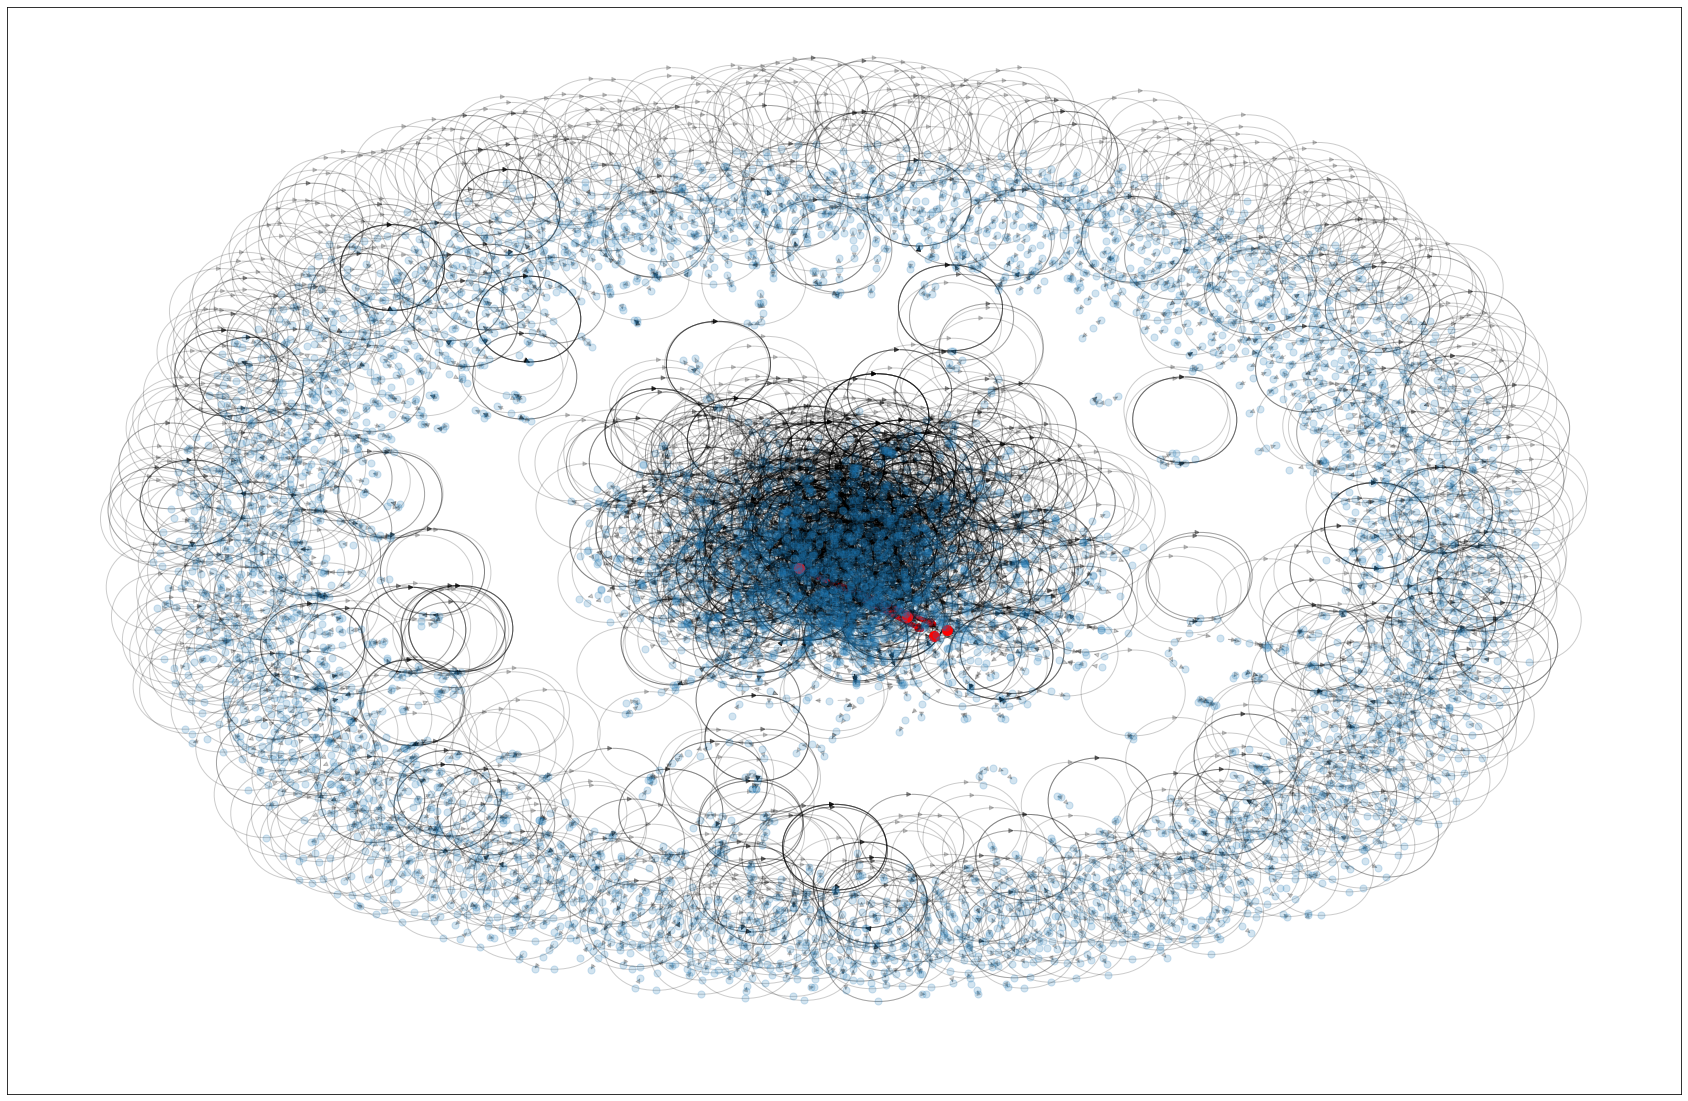

In [76]:
visualize_network(subg_1, to_remove)

In [56]:
nx_g = nx.MultiGraph(subg_1)
nx_g.number_of_nodes()

6983

In [ ]:
visualize_network(subg_1)

In [ ]:
df_g1.shape

In [ ]:
len(subg_1.keys())